In [1]:
import pandas as pd
from common import (k_means_clustering, 
                    hierarchical_clustering,
                    gmm_clustering,
                    visualize_2d, 
                    visualize_3d)
import torch
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import concurrent.futures

In [2]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # to avoid warning from sklearn  

## Read data

In [3]:
file_path = 'features.csv'
df = pd.read_csv(file_path)

In [4]:
additional_features = pd.read_csv('faces/csv/additional_features_margin_10%.csv')
# rename column filename
additional_features = additional_features.rename(columns={'filename': 'Image Name'})

df = df.merge(additional_features, on='Image Name')
df.head()

,Image Name,0,1,2,3,4,5,6,7,8,...,507,508,509,510,511,eyes_width,lips_width,eyes_lips_distance,angle_eyes_nose,angle_lips_nose
0,10003541_1937-09-27_1971.jpg,0.778738,0.012839,0.346772,1.479098,0.046364,0.451576,0.010015,1.249176,0.032536,...,0.440314,0.653740,1.071660,0.279231,0.029799,0.465768,0.406061,0.342520,1.548578,1.618201
1,10004299_1908-08-19_1950.jpg,0.159114,0.489332,0.496255,0.072993,0.048347,0.621693,0.111419,0.170238,0.077568,...,0.156734,0.193554,0.652034,0.253720,0.261395,0.474542,0.409263,0.357535,1.375667,1.617274
2,10005947_1981-04-07_2006.jpg,0.338877,0.857652,0.564472,3.262514,0.024964,0.027349,0.415986,0.964424,0.839441,...,0.200174,0.905153,0.568651,0.147718,0.218748,0.461045,0.393276,0.349658,1.489564,1.668123
3,1000781_1930-07-07_2008.jpg,0.048378,0.303481,0.581326,1.860996,0.183198,1.034714,0.491525,0.816733,0.022855,...,0.483074,0.148747,0.987068,0.000000,0.084992,0.466048,0.409249,0.388199,1.570796,1.430033
4,100131_1926-09-06_1986.jpg,0.770636,0.245071,0.528895,1.722356,0.122626,0.467538,0.323259,1.545679,0.073020,...,0.585904,0.233522,0.572238,1.562235,0.182656,0.450536,0.377545,0.359166,1.403826,1.440760


In [5]:
# add features as column

df['tensor'] = [torch.tensor(x, dtype=torch.float32) for x in df.drop(columns=['Image Name']).values]

In [6]:
df = df[['Image Name', 'tensor']]

In [7]:
df.head()

,Image Name,tensor
0,10003541_1937-09-27_1971.jpg,"[tensor(0.7787), tensor(0.0128), tensor(0.3468..."
1,10004299_1908-08-19_1950.jpg,"[tensor(0.1591), tensor(0.4893), tensor(0.4963..."
2,10005947_1981-04-07_2006.jpg,"[tensor(0.3389), tensor(0.8577), tensor(0.5645..."
3,1000781_1930-07-07_2008.jpg,"[tensor(0.0484), tensor(0.3035), tensor(0.5813..."
4,100131_1926-09-06_1986.jpg,"[tensor(0.7706), tensor(0.2451), tensor(0.5289..."


## Clustering

In [8]:
tensor_list = df['tensor'].tolist()
features = torch.stack(tensor_list)

In [9]:
# normalize features
features = (features - features.mean(dim=0)) / features.std(dim=0)

In [10]:
N_CLUSTERS = 5
CLUSTERING_METHOD = 'kmeans'
labels = None
if CLUSTERING_METHOD == 'kmeans':
    labels = k_means_clustering(features, N_CLUSTERS)
elif CLUSTERING_METHOD == 'hierarchical':
    labels = hierarchical_clustering(features, N_CLUSTERS)
elif CLUSTERING_METHOD == 'gmm':
    labels = gmm_clustering(features, N_CLUSTERS)
else:
    raise ValueError(f'Invalid clustering method: {CLUSTERING_METHOD}')

In [11]:
# find centroids
centroids = []
for i in range(N_CLUSTERS):
    cluster = features[labels == i]
    centroid = cluster.mean(dim=0)
    centroids.append(centroid)

In [12]:
def compute_silhouette_score(n_clusters):
    k_means_labels = k_means_clustering(features, n_clusters)
    k_means_silhouette_score = silhouette_score(features, k_means_labels)

    hierarchical_labels = hierarchical_clustering(features, n_clusters)
    hierarchical_silhouette_score = silhouette_score(features, hierarchical_labels)

    return max(k_means_silhouette_score, hierarchical_silhouette_score)

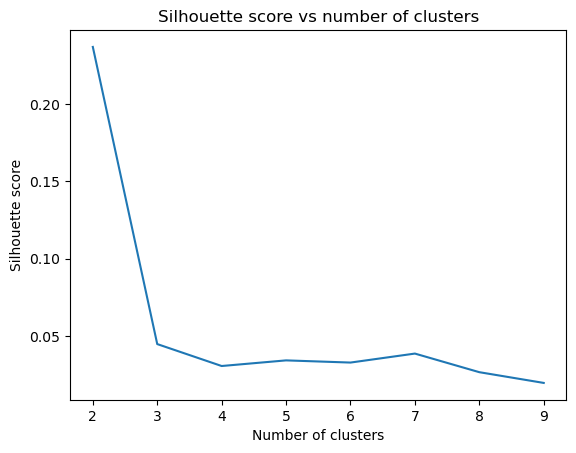

In [13]:
silhouette_scores = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for score in executor.map(compute_silhouette_score, range(2, 10)):
        silhouette_scores.append(score)

plt.plot(range(2, 10), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score vs number of clusters')
plt.show()

## Visualization

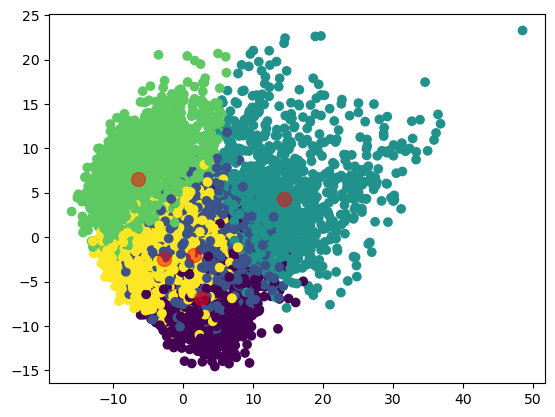

In [14]:
visualize_2d(features, centroids, labels)

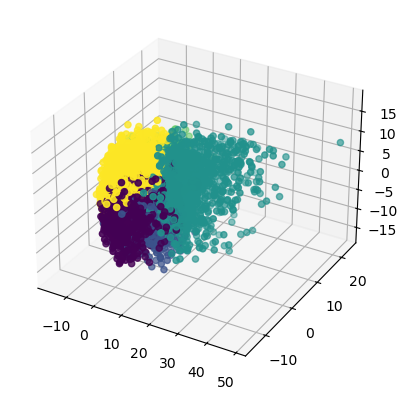

In [15]:
visualize_3d(features, centroids, labels)

## Get samples from each cluster

In [16]:
images_folder = './data/images/'

In [17]:
def plot_images(images, labels, images_folder):
    n = len(images)
    nrows = int(np.ceil(n / 5))
    fig, axs = plt.subplots(nrows, 5, figsize=(15, 3 * nrows))
    axs = axs.ravel()  # flatten the array to easily iterate over it
    for i, (img_name, label) in enumerate(zip(images, labels)):
        img = cv2.imread(os.path.join(images_folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(f'Cluster {label}')
        axs[i].axis('off')
    # remove the axes of the extra subplots
    if n % 5 != 0:
        for j in range(n, nrows * 5):
            fig.delaxes(axs[j])
    plt.tight_layout()
    plt.show()

In [18]:
# add labels to df
df['labels'] = labels

In [19]:
df.head()

,Image Name,tensor,labels
0,10003541_1937-09-27_1971.jpg,"[tensor(0.7787), tensor(0.0128), tensor(0.3468...",3
1,10004299_1908-08-19_1950.jpg,"[tensor(0.1591), tensor(0.4893), tensor(0.4963...",4
2,10005947_1981-04-07_2006.jpg,"[tensor(0.3389), tensor(0.8577), tensor(0.5645...",3
3,1000781_1930-07-07_2008.jpg,"[tensor(0.0484), tensor(0.3035), tensor(0.5813...",4
4,100131_1926-09-06_1986.jpg,"[tensor(0.7706), tensor(0.2451), tensor(0.5289...",0


In [20]:
# get samples from each cluster
sample_count = 5
samples = []
for i in range(N_CLUSTERS):
    from_cluster = df[df['labels'] == i].copy()  # create a copy to avoid warnings
    from_cluster = from_cluster[
        from_cluster['Image Name'].apply(lambda x: os.path.exists(os.path.join(images_folder, x)))]
    from_cluster.loc[:, 'distance'] = from_cluster['tensor'].apply(lambda x: torch.dist(x, centroids[i]))
    from_cluster = from_cluster.sort_values(by='distance')
    samples.append(from_cluster.head(sample_count))

samples_df = pd.concat(samples)

In [21]:
samples_df

,Image Name,tensor,labels,distance
1310,159381_1957-09-12_2010.jpg,"[tensor(0.5723), tensor(0.4931), tensor(0.4561...",0,tensor(17.9677)
7871,7406386_1976-02-26_2013.jpg,"[tensor(0.4734), tensor(0.5029), tensor(1.3475...",0,tensor(17.9738)
461,11905699_1957-12-13_2006.jpg,"[tensor(0.8809), tensor(0.6013), tensor(0.5236...",0,tensor(17.9766)
7700,6951166_1930-08-12_2011.jpg,"[tensor(0.8021), tensor(0.4393), tensor(0.3558...",0,tensor(18.0327)
6297,4280416_1959-11-07_2008.jpg,"[tensor(0.4703), tensor(0.7381), tensor(0.7250...",0,tensor(18.1753)
7736,704258_1953-01-15_1990.jpg,"[tensor(0.), tensor(0.9675), tensor(0.4405), t...",1,tensor(18.4695)
2523,21712812_1893-12-18_1960.jpg,"[tensor(0.3013), tensor(0.1802), tensor(0.8540...",1,tensor(18.5384)
3232,25159812_1991-09-20_2011.jpg,"[tensor(0.2127), tensor(0.1731), tensor(0.0531...",1,tensor(18.7008)
1803,18406330_1946-04-12_1993.jpg,"[tensor(0.0115), tensor(0.7884), tensor(0.4423...",1,tensor(18.7242)
5864,40348617_1907-02-09_1941.jpg,"[tensor(0.), tensor(0.3603), tensor(1.2012), t...",1,tensor(18.9194)


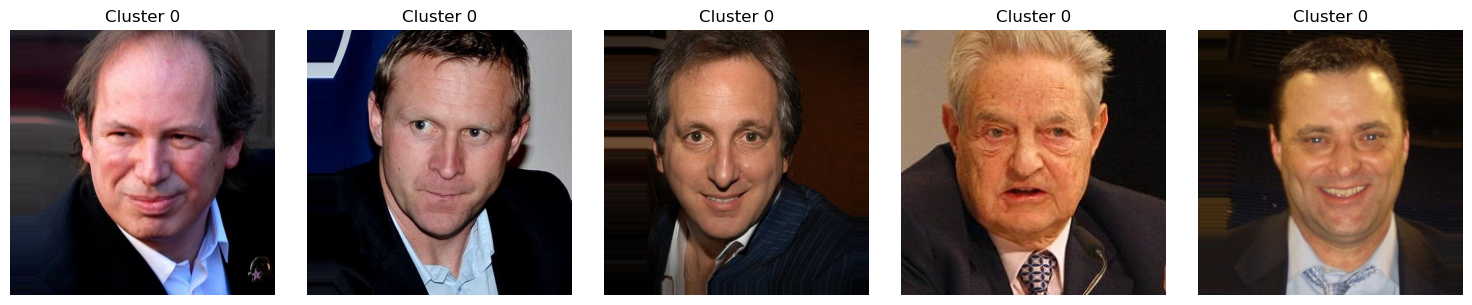

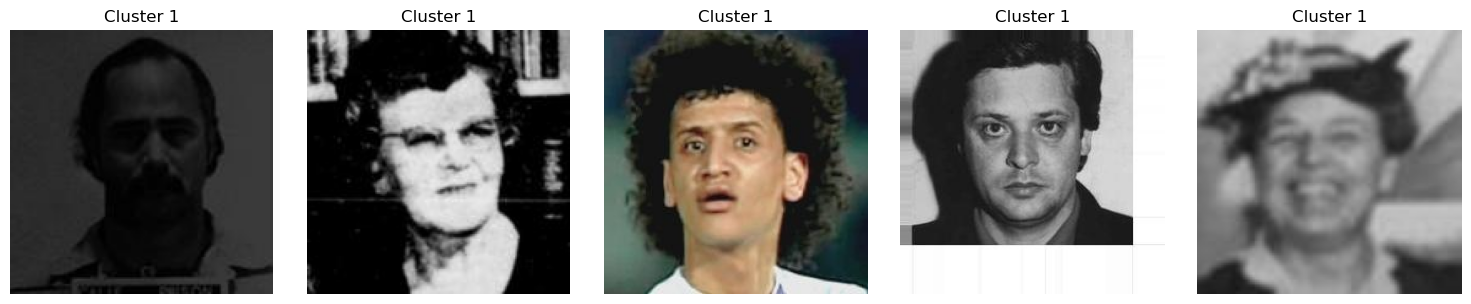

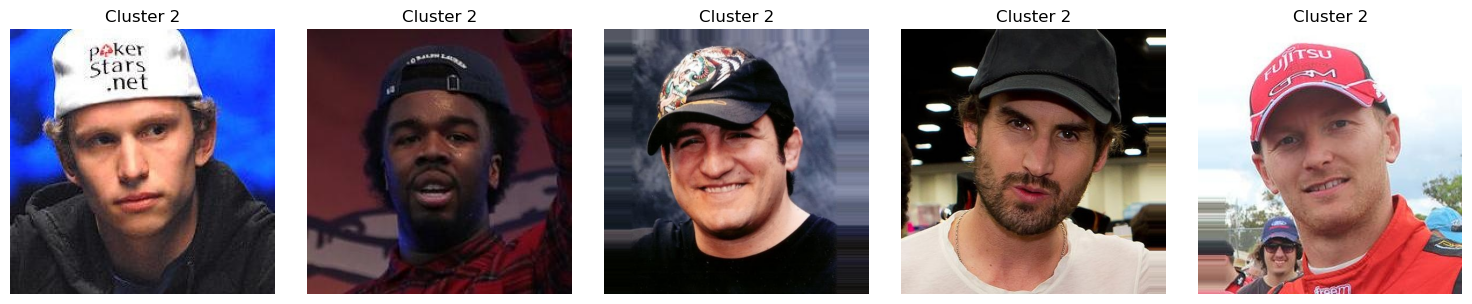

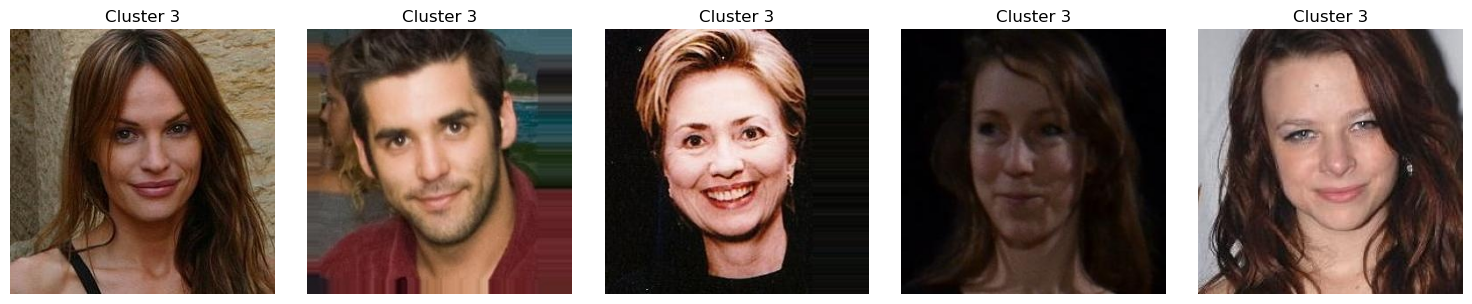

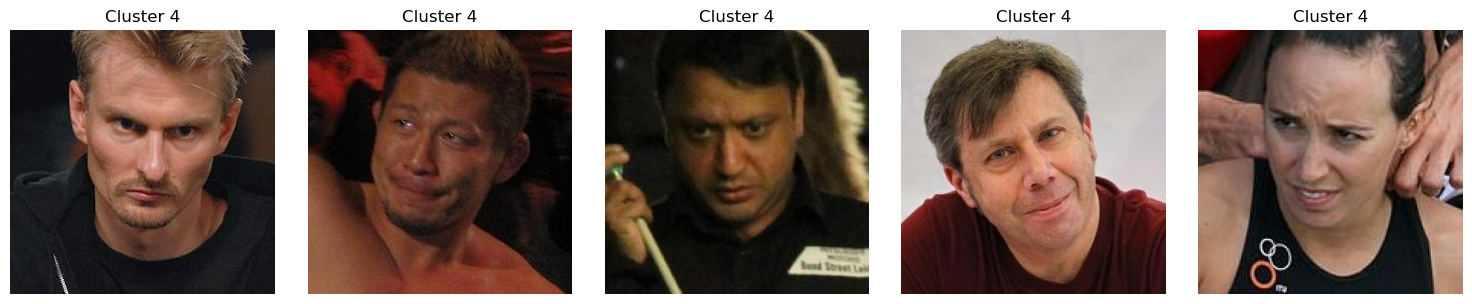

In [22]:
# plot samples for each cluster
for i in range(N_CLUSTERS):
    cluster_samples = samples_df[samples_df['labels'] == i]
    plot_images(cluster_samples['Image Name'].values, cluster_samples['labels'].values, images_folder)

In [34]:
DATA_FOLDER = 'data/'
WIKI_FOLDER = 'wiki_crop/'
IMAGES_FOLDER = 'images/'
CSV_FOLDER = 'faces/csv/'

FACES_FOLDER = 'faces/margin_10%/'

margin = 0.1
SUFFIX = f'margin_{int(margin*100)}%'

In [35]:
def get_image_paths(folder):
    return [folder + f for f in os.listdir(folder) if f.endswith('.jpg')]

image_paths = get_image_paths(FACES_FOLDER)
image_paths = np.array(image_paths)

In [37]:
from tqdm import tqdm

In [38]:
def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    assert img is not None

    if img.shape[:2] == (1, 1):
        return {
            'folder': None,
            'file': None,
            'image': None
        }

    split = image_path.split('/')
    folder = split[-2]
    file = split[-1]

    return {
        'folder': folder,
        'file': file,
        'image': img
    }


images = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(read_image, image_path) for image_path in image_paths]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(image_paths)):
        if future.result()['image'] is not None:
            images.append(future.result())

images = pd.DataFrame().from_dict(images)

100%|██████████| 8642/8642 [00:01<00:00, 8202.82it/s]


In [40]:
CLUSTERS_FOLDER = 'clusters/'

if not os.path.exists(CLUSTERS_FOLDER):
    os.makedirs(CLUSTERS_FOLDER)
    
for i in range(N_CLUSTERS):
    cluster_samples = samples_df[df['labels'] == i]
    
    clusters_subfolder = os.path.join(CLUSTERS_FOLDER, f'cluster_{i}/')
    if not os.path.exists(clusters_subfolder):
        os.makedirs(clusters_subfolder)
    
    for filename in df['Image Name']:
        img = images[images['file'] == filename]['image'].values[0]
        cv2.imwrite(clusters_subfolder + filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

C:\Users\balanton\AppData\Local\Temp\ipykernel_23600\2930442911.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_samples = samples_df[df['labels'] == i]
C:\Users\balanton\AppData\Local\Temp\ipykernel_23600\2930442911.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_samples = samples_df[df['labels'] == i]
C:\Users\balanton\AppData\Local\Temp\ipykernel_23600\2930442911.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_samples = samples_df[df['labels'] == i]
C:\Users\balanton\AppData\Local\Temp\ipykernel_23600\2930442911.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_samples = samples_df[df['labels'] == i]
C:\Users\balanton\AppData\Local\Temp\ipykernel_23600\2930442911.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cluster_samples = samples_df[df['labels'] == i]
